In [1]:
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
    
    
import numpy as np
import corner
from matplotlib import pyplot as plt
import seaborn as sns

import emcee
from emcee.autocorr import integrated_time

#%matplotlib notebook

In [2]:
#, 'H0', 'Om0'

n_disc = 1000 # burn-in
names = ['DLR_val_2', 'DLR_val_3', 'DLR_val_4', 'DLR_val_5', 'DLR_corr_length', \
         'BR_val_1', 'BR_val_2', 'BR_val_3', 'BR_val_4', 'BR_corr_length', 'w0', 'H0', 'Om0']
labels = ['DLR_val_2', 'DLR_val_3', 'DLR_val_4', 'DLR_val_5', 'DLR_corr_length', \
         'BR_val_1', 'BR_val_2', 'BR_val_3', 'BR_val_4', 'BR_corr_length', 'w0', 'H0', 'Om0']

filename = "Data/chains/var_cosmo_reconstruction_ET_a.h5"
backend = emcee.backends.HDFBackend(filename, read_only=True)
data = backend.get_chain()


autocorr = np.mean(backend.get_autocorr_time())
print("Mean autocorrelation time: {0:.3f} steps".format(autocorr))

Mean autocorrelation time: 355.252 steps


(58500,)
AIC (min chi^2 + 2#params) =  10586.400762906178


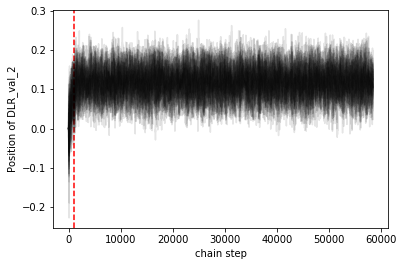

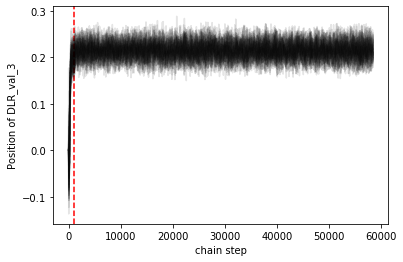

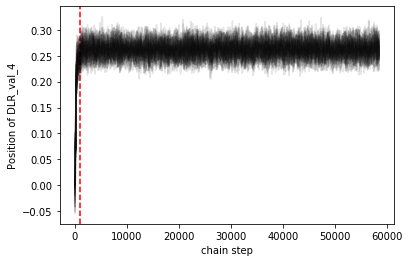

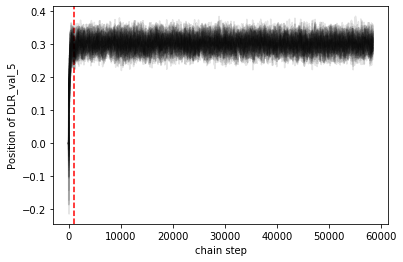

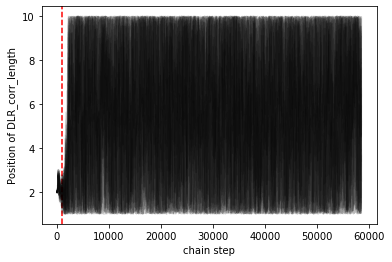

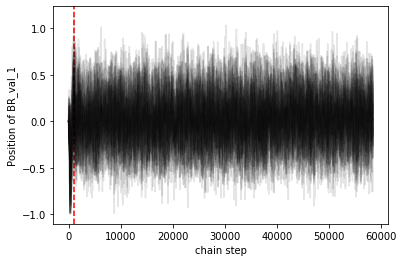

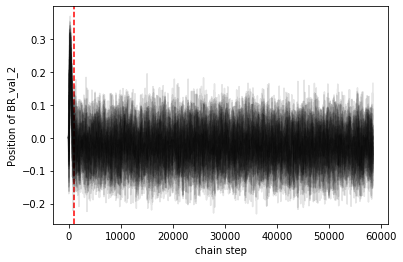

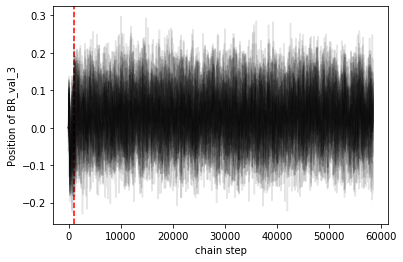

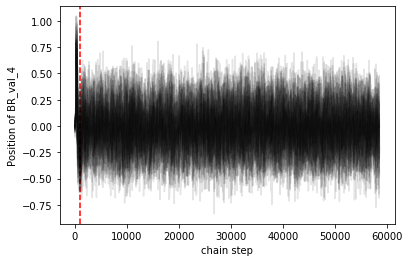

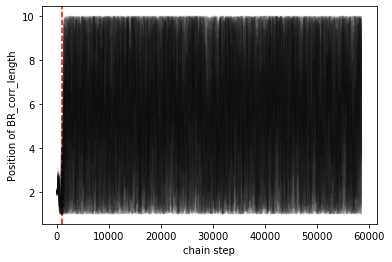

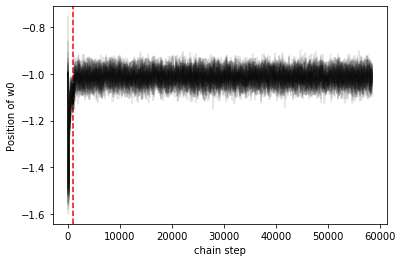

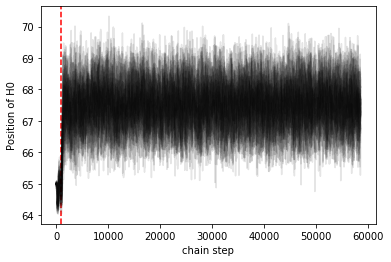

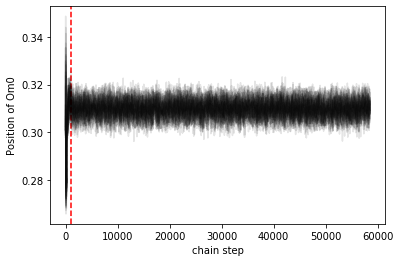

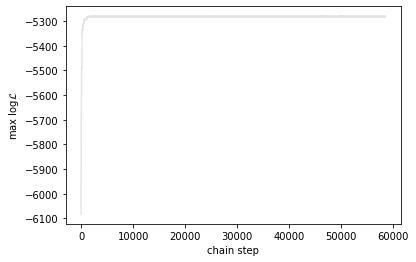

In [3]:
data = backend.get_chain()

for i in np.arange(13):
    plt.figure()
    plt.gca().set_xlabel('chain step')
    plt.gca().set_ylabel(r"Position of "+names[i])
    plt.axvline(n_disc, c='r', ls='--')
    plt.plot(data[:, :, i], c='k', alpha=0.1)
    

#discard=n_disc    
lnprob = backend.get_log_prob()
print(np.shape(lnprob[:, :].max(axis=1)))
print("AIC (min chi^2 + 2#params) = ", -2.*max(lnprob[:, :].max(axis=1)) + 2.*len(names))

plt.figure()
plt.gca().set_xlabel('chain step')
plt.gca().set_ylabel(r"max $\log \mathcal{L}$")
plt.plot(lnprob[:, :].max(axis=1), c='k', alpha=0.1)
#plt.gca().set_ylim([-3, 0])
plt.show()

In [4]:
samps = backend.get_chain(flat = True, discard=n_disc)


DLR2, DLR3, DLR4, DLR5, DLR_corr_length, BR1, BR2, BR3, BR4, BR_corr_length, w0, H0, Om0 = map(
                                lambda v: (v[0]), zip(*np.percentile(samps, [50], axis=0))
                                                            )

print(DLR2, DLR3, DLR4, DLR5, DLR_corr_length, BR1, BR2, BR3, BR4, BR_corr_length, w0, H0, Om0)

0.11885402502896728 0.21472051048830146 0.2619952272891129 0.30122505169279534 5.652987303439598 0.01851695941118442 -0.025763773507129672 0.03238339516985943 -0.01940623270836314 5.696519864132724 -1.0142506130294637 67.49813349956833 0.30987695389848785


In [5]:
from src.GWGC_cross_corr import *
from specifications import *

#GPs regressors
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

#getdist
from getdist import loadMCSamples, MCSamples


import time

In [6]:
def GP(training_pos, training_vals, correlation_length, z_lst):

    kernel = RBF(correlation_length, (correlation_length, correlation_length))
    gp = GaussianProcessRegressor(kernel=kernel)
    
    gp.fit(np.array(training_pos)[:,np.newaxis], training_vals)
    
    return gp.predict(z_lst[:, np.newaxis])


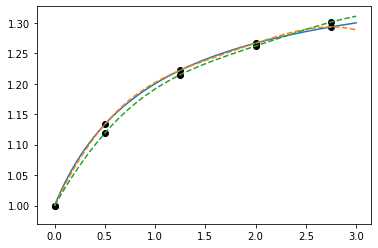

In [7]:
# Sampling of redshift
zs = np.linspace(1e-3, 3., 50)
dz = zs[1] - zs[0]

z_length = len(zs)


DLR_fid, BR_fid = fiducial_ratios(z_lst)

training_pos_DLR = np.array([0., 0.5, 1.25, 2., 2.75])
training_pos_BR = np.array([0., 1., 2., 3.])

training_vals_DLR_fid = fiducial_ratios(training_pos_DLR)[0] - 1.
training_vals_DLR_fid[1] = training_vals_DLR_fid[1] - 0.
training_vals_DLR_fid[2] = training_vals_DLR_fid[2] + 0.
training_vals_BR_fid = fiducial_ratios(training_pos_BR)[1] - 1.

training_vals_DLR_bf = np.array([0., DLR2, DLR3, DLR4, DLR5])
training_vals_BR_bf = np.array([BR1, BR2, BR3, BR4])

correlation_length = 2.
DLR_fid_gp = GP(training_pos_DLR, training_vals_DLR_fid, correlation_length, z_lst) + 1.
BR_fid_gp = GP(training_pos_BR, training_vals_BR_fid, correlation_length, z_lst) + 1.
DLR_bf = GP(training_pos_DLR, training_vals_DLR_bf, correlation_length, z_lst) + 1.
BR_bf = GP(training_pos_BR, training_vals_BR_bf, correlation_length, z_lst) + 1.

### --- For writing in the file later
DLR_bf_coarse = GP(training_pos_DLR, training_vals_DLR_bf, correlation_length, zs) + 1.
BR_bf_coarse = GP(training_pos_BR, training_vals_BR_bf, correlation_length, zs) + 1.
alpha_M_bf_coarse = np.gradient(DLR_bf_coarse, zs)*(1. + zs)*2./DLR_bf_coarse



fig = plt.figure()
ax = fig.gca()

ax.scatter(training_pos_DLR, training_vals_DLR_fid + 1., color='black')
ax.scatter(training_pos_DLR, training_vals_DLR_bf + 1., color='black')
ax.plot(z_lst, DLR_fid)

ax.plot(z_lst, DLR_fid_gp, '--')
ax.plot(z_lst, DLR_bf, '--')

[ 0.13333333  0.22222222  0.26666667  0.29333333  2.          0.
  0.          0.          0.          2.         -1.         67.66
  0.3111    ]


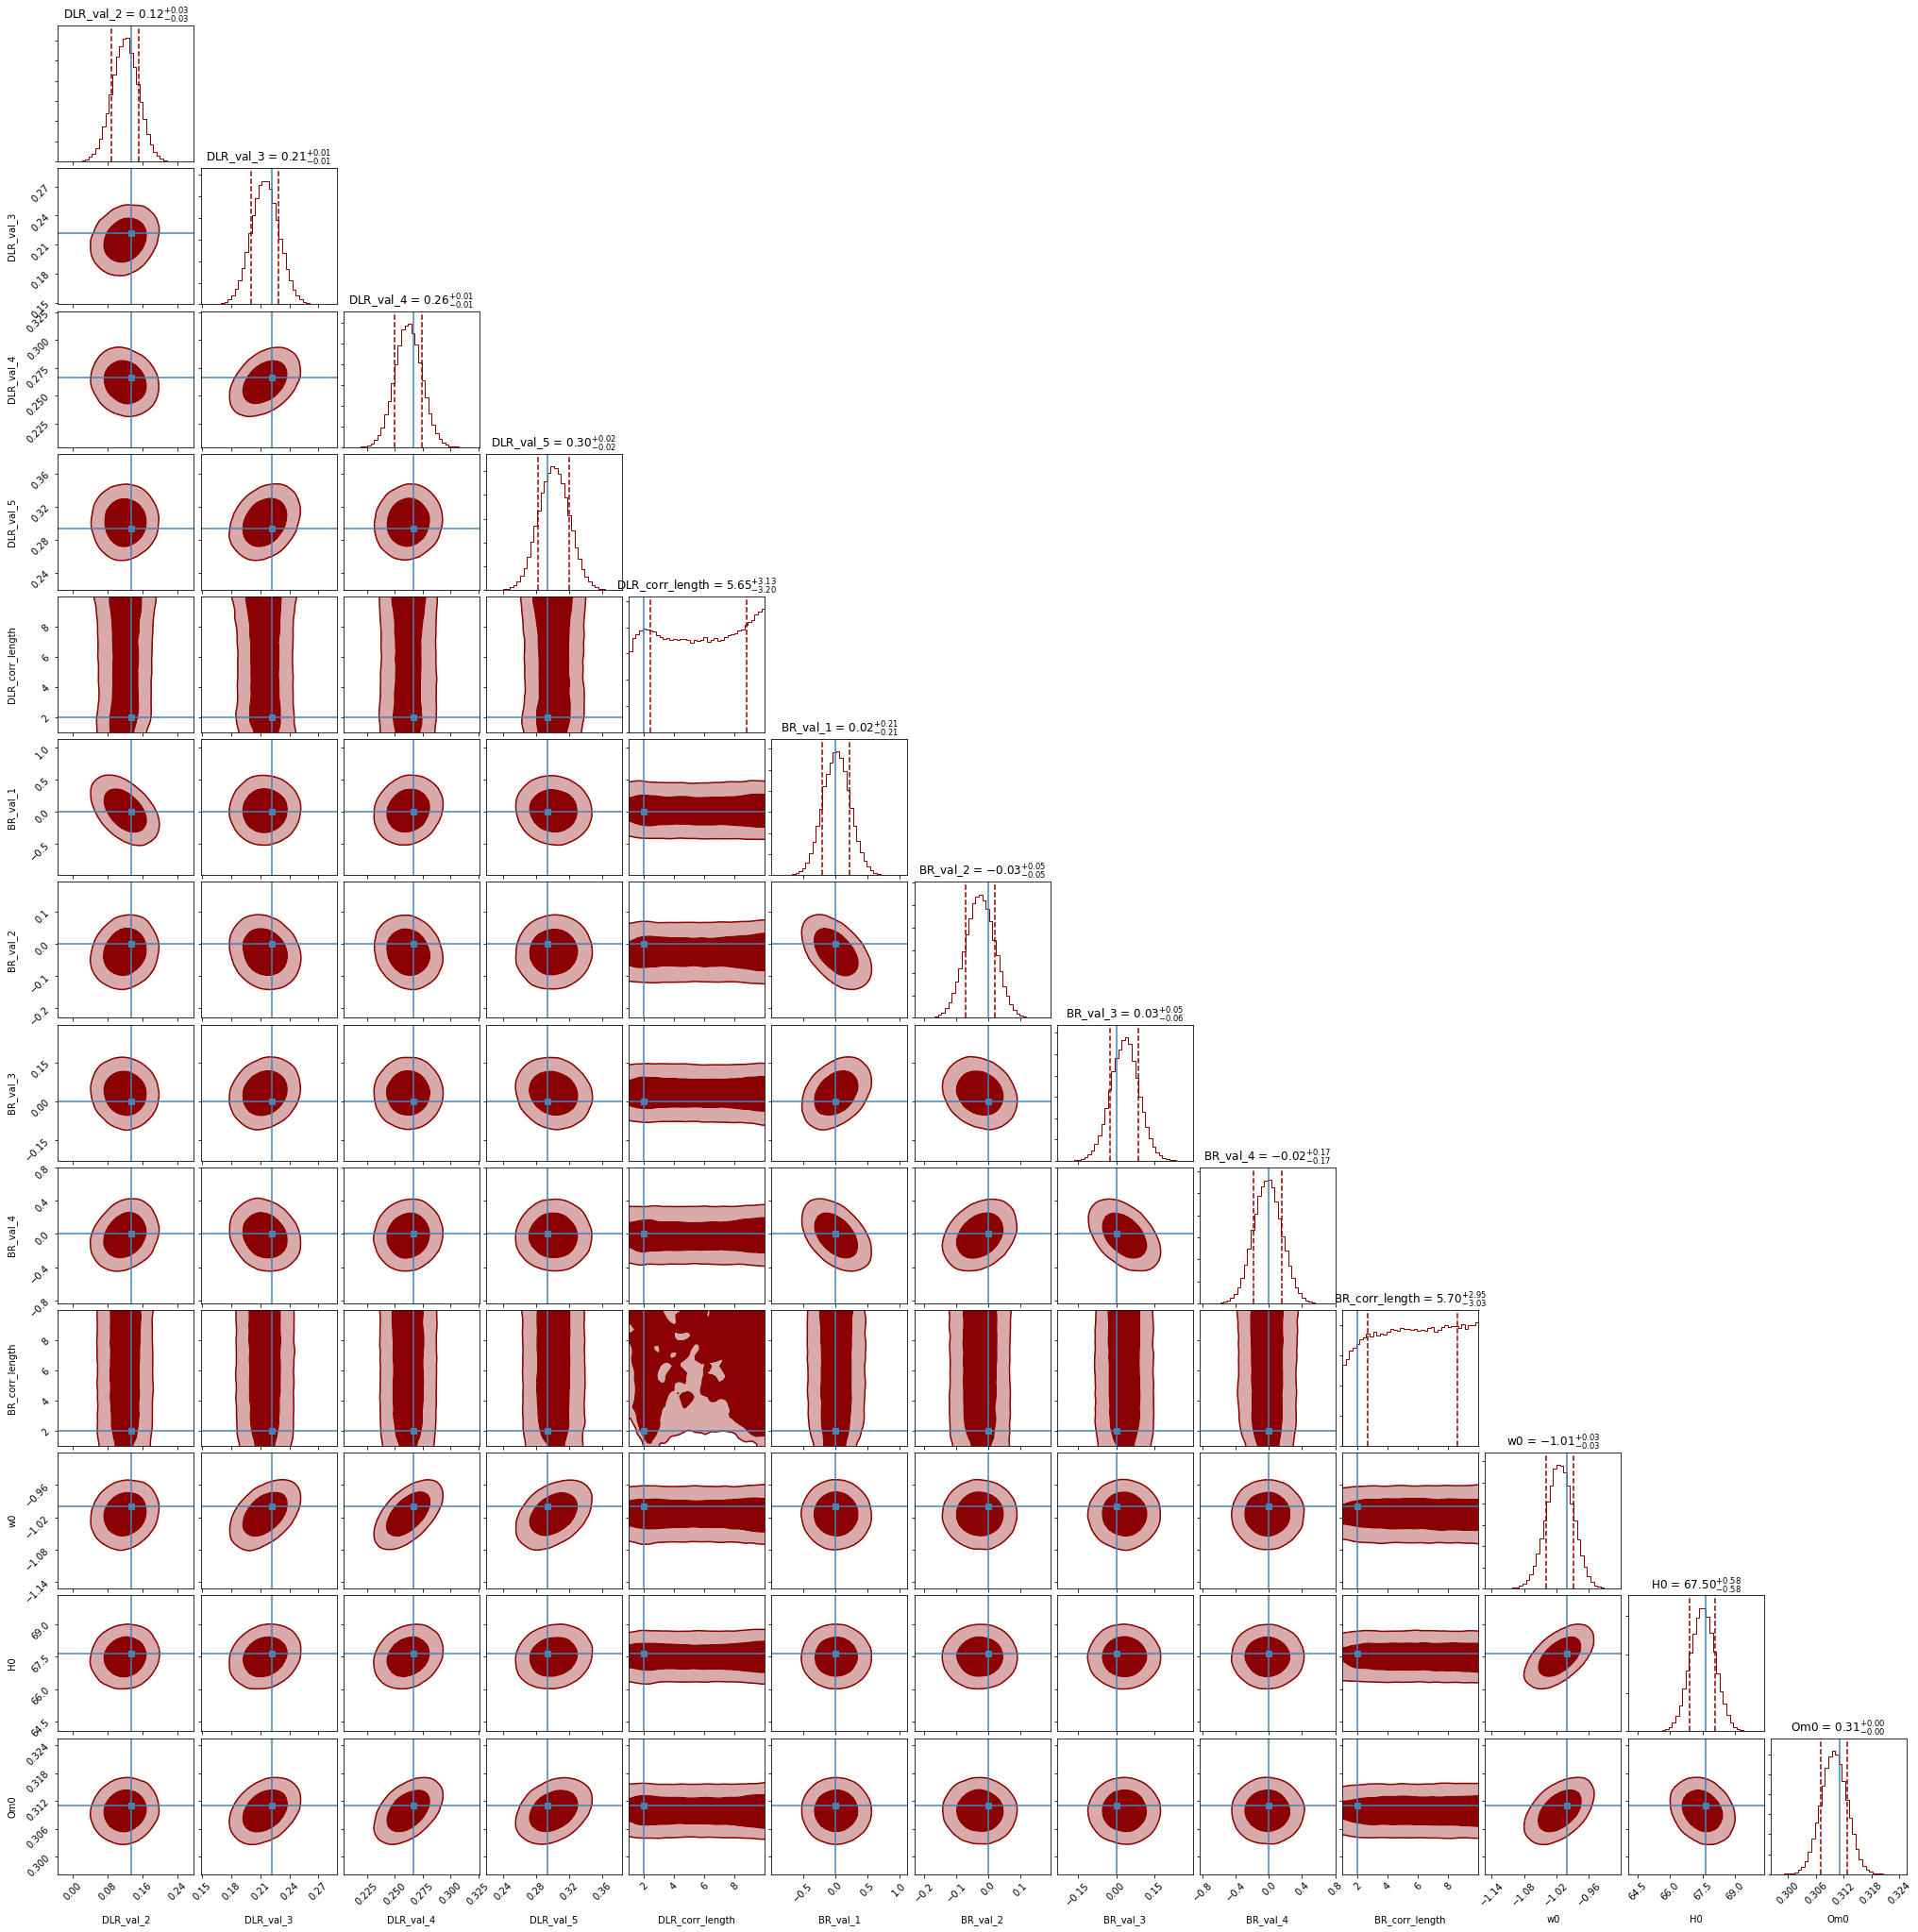

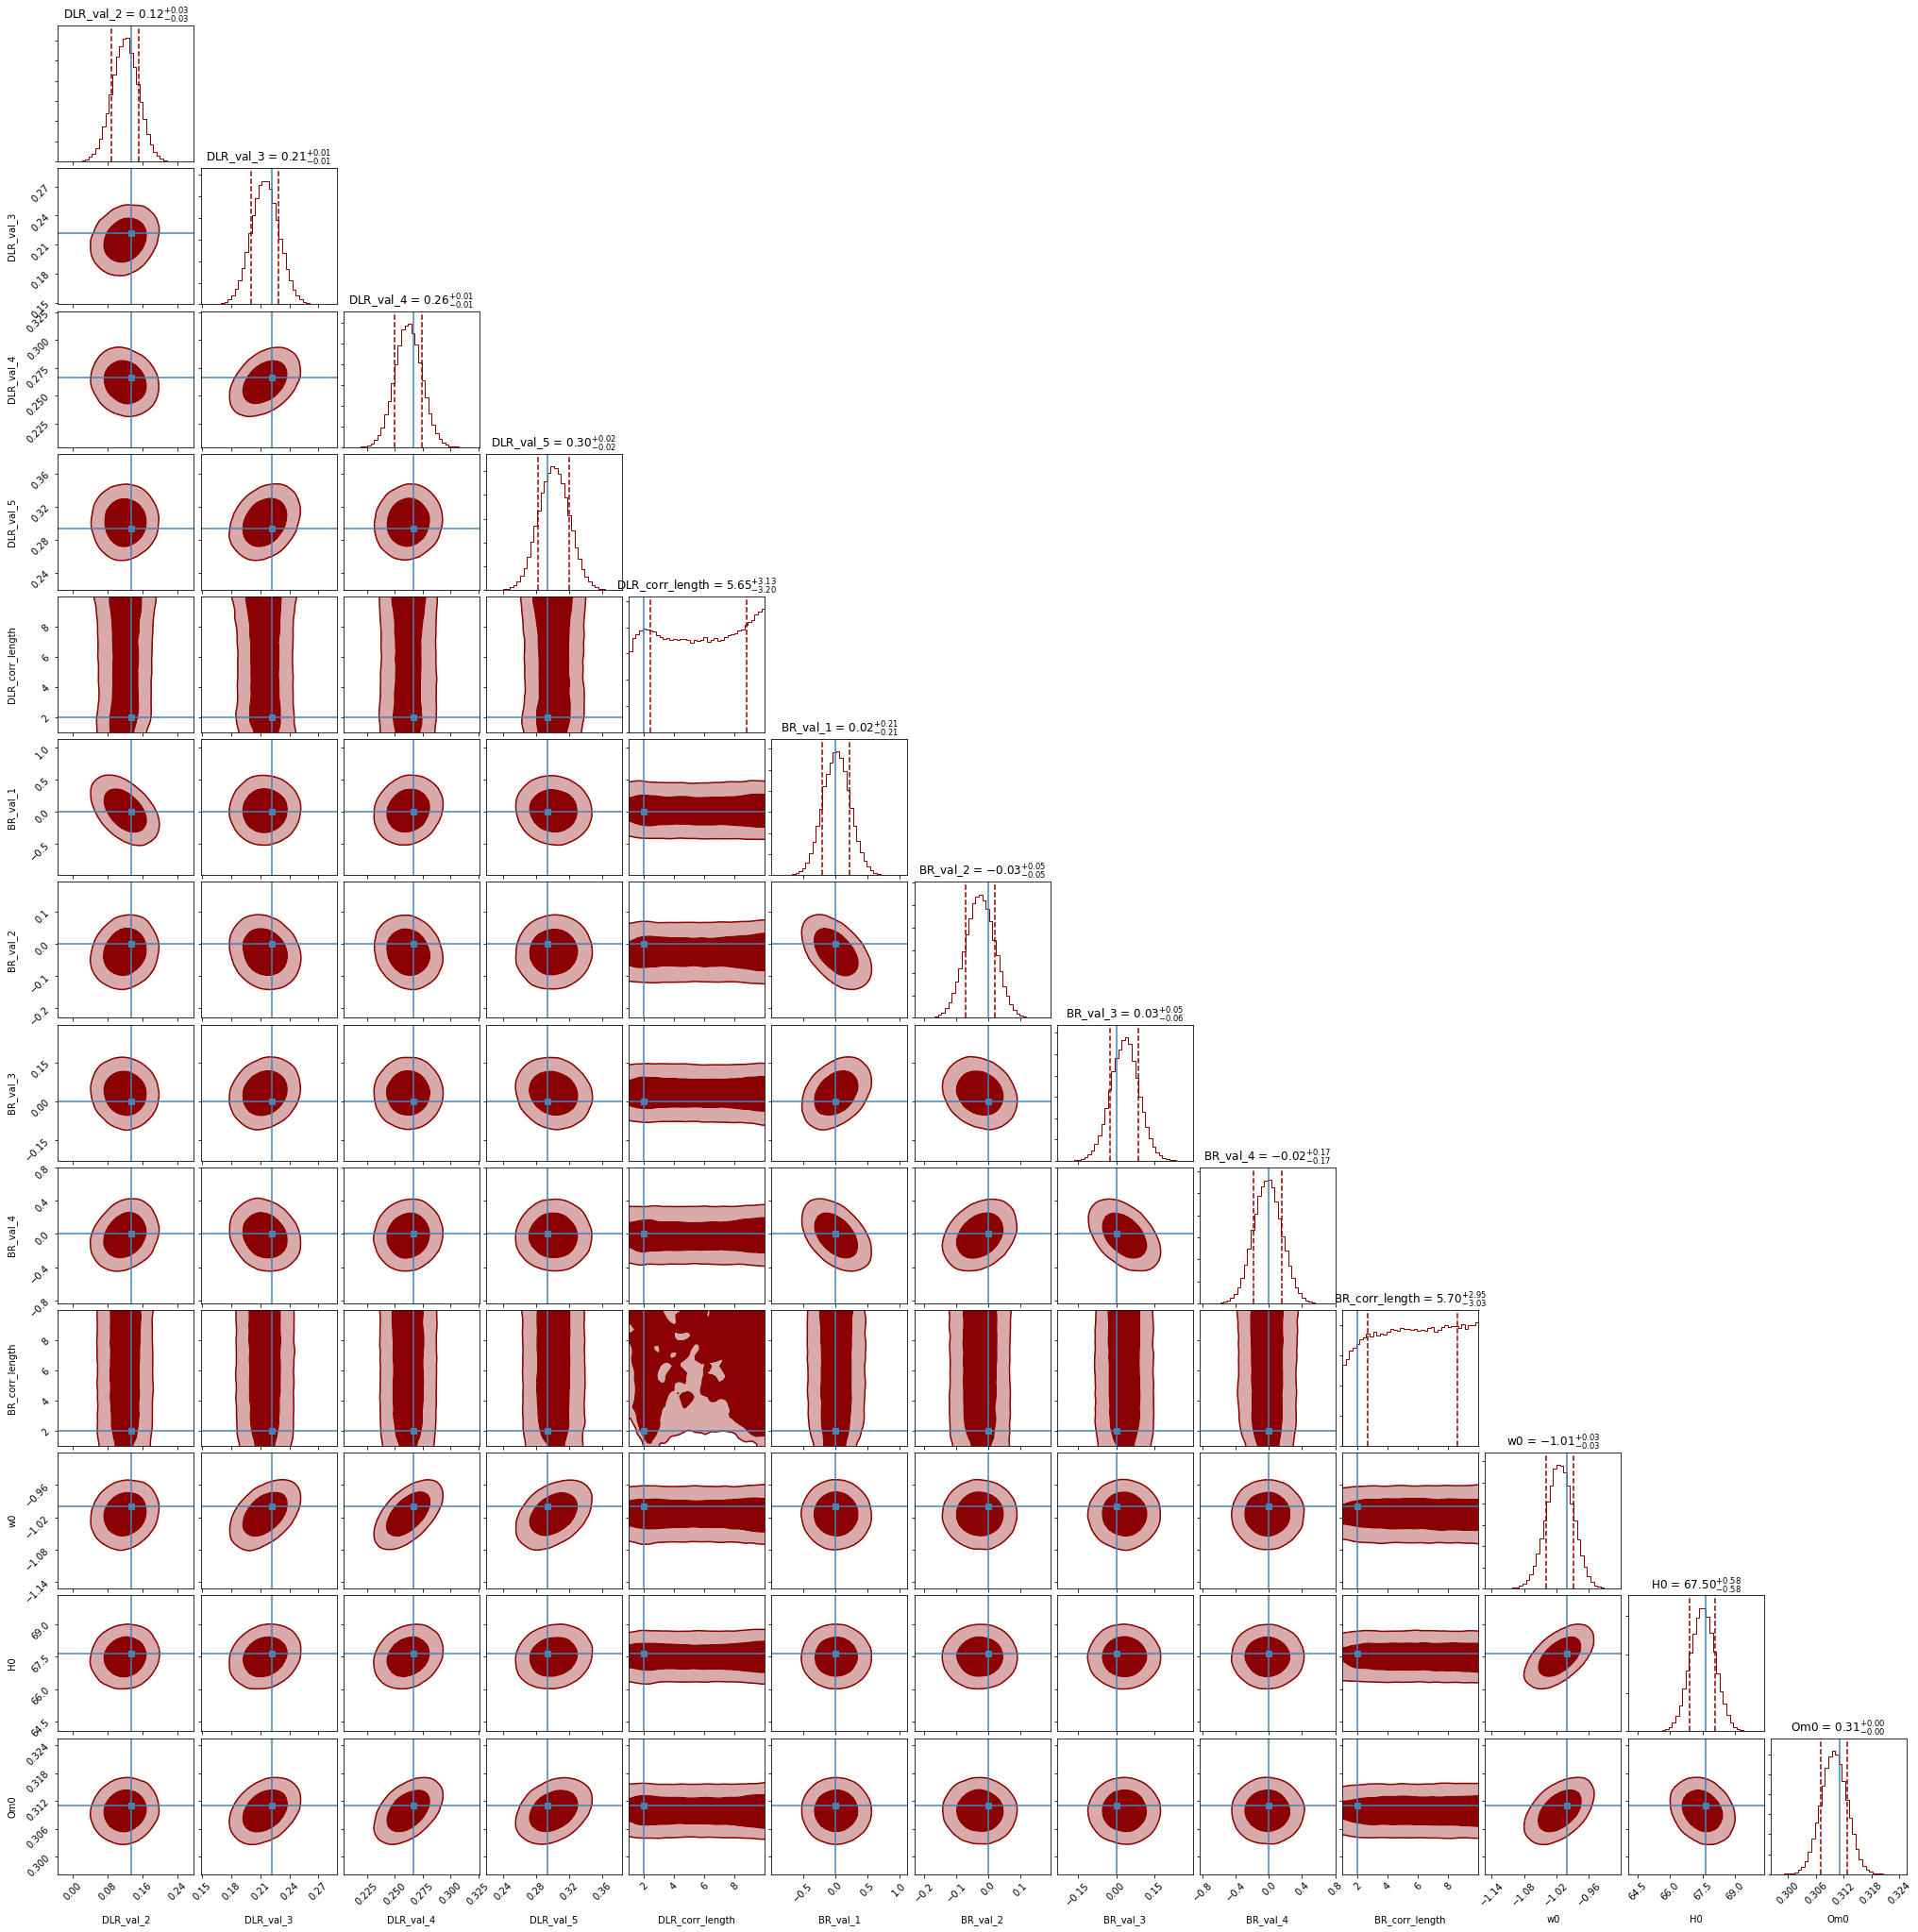

In [8]:
truths = np.array(training_vals_DLR_fid)[1:5]
truths = np.append(truths, correlation_length)
truths = np.append(truths, training_vals_BR_fid)
truths = np.append(truths, correlation_length)
truths = np.append(truths, [-1., 67.66, 0.3111])

print(truths)
corner.corner(samps, labels=labels, show_titles=True, \
              plot_datapoints=False, plot_density=False, \
              quantiles=(0.16, 0.84), levels=(0.68, 0.95), \
              fill_contours=True, color = 'darkred', smooth = True, bins = 40, truths = truths)


In [9]:
every = int(autocorr)
print(np.shape(samps))

z_length = len(zs)
sample_length = len(samps[:, 0][::every])

L = np.ones(sample_length)
DLR_vals = np.array([L - 1., samps[:, 0][::every], 
                        samps[:, 1][::every], 
                        samps[:, 2][::every], 
                        samps[:, 3][::every]])
DLR_pos = np.array([min(zs)*L, 0.5*L, 1.25*L, 2.*L, 2.75*L]) 
DLR_correlation_lengths = samps[:, 4][::every]

BR_vals = np.array([samps[:, 5][::every], 
                    samps[:, 6][::every], 
                    samps[:, 7][::every], 
                    samps[:, 8][::every]])
BR_pos = np.array([min(zs)*L, 1.*L, 2.*L, 3.*L]) 
BR_correlation_lengths = samps[:, 9][::every]


(1495000, 13)


In [12]:
labels = ["DLR", "BR"]
names = ["DLR", "BR"]


DLR_all = np.zeros((sample_length, z_length))
alpha_M_all = np.zeros((sample_length, z_length))
BR_all = np.zeros((sample_length, z_length))
    
for indx in range(sample_length):
        
    DLR_tmp = GP(DLR_pos[:,indx], DLR_vals[:,indx], 1., np.array(zs)) + 1.
    alpha_M_tmp = np.gradient(DLR_tmp, zs)*(1. + zs)*2./DLR_tmp
    BR_tmp = GP(BR_pos[:,indx], BR_vals[:,indx], 1., np.array(zs)) + 1.
    
    DLR_all[indx] = DLR_tmp
    alpha_M_all[indx] = alpha_M_tmp
    BR_all[indx] = BR_tmp
    
    if np.mod(indx, 500) == 0:
        print(int(100*float(indx)/sample_length), "% Completed")

0 % Completed
11 % Completed
23 % Completed
35 % Completed
47 % Completed
59 % Completed
71 % Completed
83 % Completed
94 % Completed


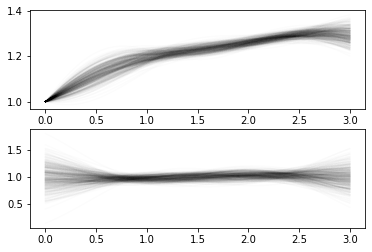

In [13]:
fig, axes = plt.subplots(2, 1)

#Density plot to see if the result below makes sense
for indx in range(sample_length):
    
    
    if np.mod(indx, 10) == 0:
        #print(100*float(indx)/len(correlation_lengths))
        
        axes[0].plot(zs, DLR_all[indx], 'k-', alpha=0.01)
        axes[1].plot(zs, BR_all[indx], 'k-', alpha=0.01)

In [14]:
DLR_mean = np.zeros(z_length)
DLR_lower1 = np.zeros(z_length)
DLR_lower2 = np.zeros(z_length)
DLR_upper1 = np.zeros(z_length)
DLR_upper2 = np.zeros(z_length)


alpha_M_mean = np.zeros(z_length)
alpha_M_lower1 = np.zeros(z_length)
alpha_M_lower2 = np.zeros(z_length)
alpha_M_upper1 = np.zeros(z_length)
alpha_M_upper2 = np.zeros(z_length)

BR_mean = np.zeros(z_length)
BR_lower1 = np.zeros(z_length)
BR_lower2 = np.zeros(z_length)
BR_upper1 = np.zeros(z_length)
BR_upper2 = np.zeros(z_length)


DLR_BR_corr_matrix = np.zeros((z_length, z_length))
DLR_DLR_corr_matrix = np.zeros((z_length, z_length))
BR_BR_corr_matrix = np.zeros((z_length, z_length))

for indx, z_tmp in enumerate(zs):
    
    print('z: ', z_tmp)
    
    samps_alpha_M = np.array(np.array(alpha_M_all[:,indx]).reshape(sample_length, 1))
    
    
    samples = MCSamples(samples = samps_alpha_M, names = ['alpha_M'], labels = ['alpha_M'])
    stats = samples.getMargeStats()
    
    #print(stats.parWithName('DLR').limits)

    alpha_M_mean[indx] = stats.parWithName('alpha_M').mean
    alpha_M_lower1[indx] = stats.parWithName('alpha_M').limits[1].lower
    alpha_M_lower2[indx] = stats.parWithName('alpha_M').limits[2].lower
    alpha_M_upper1[indx] = stats.parWithName('alpha_M').limits[1].upper
    alpha_M_upper2[indx] = stats.parWithName('alpha_M').limits[2].upper
    
    

for indx_1, z_tmp_1 in enumerate(zs):
    
    print('z: ', z_tmp_1)
    
    samps_DLR = np.array(np.array(DLR_all[:,indx_1]).reshape(sample_length, 1))
    samps_BR = np.array(np.array(BR_all[:,indx_1]).reshape(sample_length, 1))
    
    samps_1 = np.stack((samps_DLR, samps_BR), axis = -1)[:,0]
    
    samples_1 = MCSamples(samples = samps_1, names = names, labels = labels)
    stats_1 = samples_1.getMargeStats()
    
    #print(stats.parWithName('DLR').limits)

    DLR_mean[indx_1] = stats_1.parWithName('DLR').mean
    DLR_lower1[indx_1] = stats_1.parWithName('DLR').limits[1].lower
    DLR_lower2[indx_1] = stats_1.parWithName('DLR').limits[2].lower
    DLR_upper1[indx_1] = stats_1.parWithName('DLR').limits[1].upper
    DLR_upper2[indx_1] = stats_1.parWithName('DLR').limits[2].upper
    
    BR_mean[indx_1] = stats_1.parWithName('BR').mean
    BR_lower1[indx_1] = stats_1.parWithName('BR').limits[1].lower
    BR_lower2[indx_1] = stats_1.parWithName('BR').limits[2].lower
    BR_upper1[indx_1] = stats_1.parWithName('BR').limits[1].upper
    BR_upper2[indx_1] = stats_1.parWithName('BR').limits[2].upper
    
    for indx_2, z_tmp_2 in enumerate(zs):
        
        samps_DLR_prime = np.array(np.array(DLR_all[:,indx_2]).reshape(sample_length, 1))
        samps_BR_prime = np.array(np.array(BR_all[:,indx_2]).reshape(sample_length, 1))
        
        #######################
        samps_2 = np.stack((samps_DLR, samps_BR_prime), axis = -1)[:,0]
        samples_2 = MCSamples(samples = samps_2, names = names, labels = labels)
        
        DLR_BR_corr_matrix[indx_1, indx_2] = samples_2.corr()[0, 1]
        #######################       
        
        #######################        
        samps_2 = np.stack((samps_DLR, samps_DLR_prime), axis = -1)[:,0]
        samples_2 = MCSamples(samples = samps_2, names = names, labels = labels)
        
        DLR_DLR_corr_matrix[indx_1, indx_2] = samples_2.corr()[0, 1]
        #######################
        
        #######################        
        samps_2 = np.stack((samps_BR, samps_BR_prime), axis = -1)[:,0]
        samples_2 = MCSamples(samples = samps_2, names = names, labels = labels)
        
        BR_BR_corr_matrix[indx_1, indx_2] = samples_2.corr()[0, 1]
        #######################


z:  0.001
Removed no burn in
z:  0.06220408163265306
Removed no burn in
z:  0.12340816326530613
Removed no burn in
z:  0.1846122448979592
Removed no burn in
z:  0.24581632653061225
Removed no burn in
z:  0.3070204081632653
Removed no burn in
z:  0.3682244897959184
Removed no burn in
z:  0.42942857142857144
Removed no burn in
z:  0.4906326530612245
Removed no burn in
z:  0.5518367346938776
Removed no burn in
z:  0.6130408163265306
Removed no burn in
z:  0.6742448979591836
Removed no burn in
z:  0.7354489795918367
Removed no burn in
z:  0.7966530612244899
Removed no burn in
z:  0.8578571428571429
Removed no burn in
z:  0.9190612244897959
Removed no burn in
z:  0.980265306122449
Removed no burn in
z:  1.041469387755102
Removed no burn in
z:  1.1026734693877551
Removed no burn in
z:  1.163877551020408
Removed no burn in
z:  1.2250816326530611
Removed no burn in
z:  1.2862857142857143
Removed no burn in
z:  1.3474897959183672
Removed no burn in
z:  1.4086938775510203
Removed no burn in
z:  

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
z:  0.1846122448979592
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed 

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no b

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no b

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no b

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
z:  0.980265306122449
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed n

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
z:  1.163877551020408
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed n

Removed no burn in
z:  1.3474897959183672
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed 

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no b

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no b

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no b

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no b

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
z:  2.326755102040816
Removed no burn in
Removed no burn in
Removed no burn in
Removed n

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
z:  2.5103673469387755
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed 

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no b

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no b

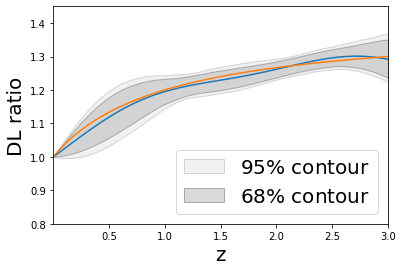

In [15]:
xi_tmp = 1.4
n = 1.
DL_ratio_fiducial = (xi_tmp + (1. - xi_tmp)/(1. + zs)**n)#np.ones(len(z_lst))


fig, ax = plt.subplots(1, )

ax.fill_between(zs, DLR_lower2, DLR_upper2, facecolor='lightgrey', edgecolor='grey', alpha=0.3,
                label=r'$95\%$ contour')
ax.fill_between(zs, DLR_lower1, DLR_upper1, facecolor='silver', edgecolor='grey', alpha=0.6,
                label=r'$68\%$ contour')
ax.plot(zs, DLR_mean)
ax.plot(zs, DL_ratio_fiducial)


ax.set_ylim([0.8, 1.45])
ax.set_xlim([min(zs), max(zs)])
ax.set_xlabel('z', fontsize=20)
ax.set_ylabel('DL ratio', fontsize=20)
ax.legend(fontsize=20, loc = 4)

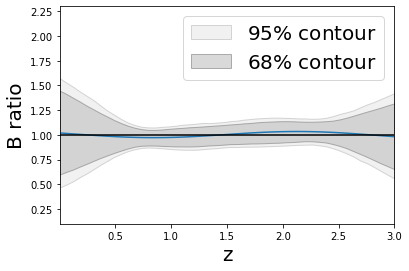

In [16]:
fig, ax = plt.subplots(1, )

ax.fill_between(zs, BR_lower2, BR_upper2, facecolor='lightgrey', edgecolor='grey', alpha=0.3,
                label=r'$95\%$ contour')
ax.fill_between(zs, BR_lower1, BR_upper1, facecolor='silver', edgecolor='grey', alpha=0.6,
                label=r'$68\%$ contour')
ax.plot(zs, BR_mean)

ax.axhline([1.], c = "k")

ax.set_ylim([0.1, 2.3])
ax.set_xlim([min(zs), max(zs)])
ax.set_xlabel('z', fontsize=20)
ax.set_ylabel('B ratio', fontsize=20)
ax.legend(fontsize=20);

(0.001, 3.0)

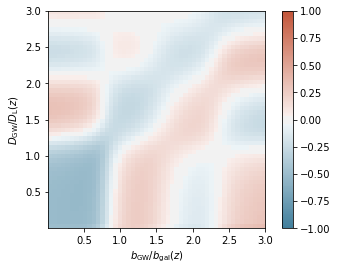

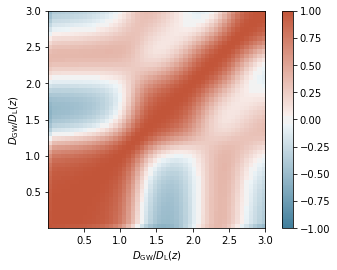

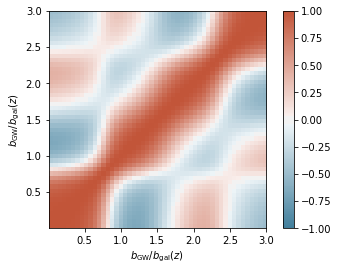

In [17]:
#, vmin = -1., vmax = 1.
z_lst = zs
corr_mat = [DLR_BR_corr_matrix, DLR_DLR_corr_matrix, BR_BR_corr_matrix]
cmap = sns.diverging_palette(230, 20, as_cmap=True)

############################################################################################################
fig = plt.figure()
ax = fig.gca()

extent=[min(z_lst), max(z_lst), min(z_lst), max(z_lst)]
c = ax.imshow(corr_mat[0], cmap = cmap, origin ='lower', extent = extent, vmin = -1., vmax = 1.) 

cbar = plt.colorbar(c) 


#ax.set_xticklabels([])
#ax.set_yticklabels([])

ax.set_ylabel(r"$D_\mathrm{GW}/D_\mathrm{L} \left(z\right)$")
ax.set_xlabel(r"$b_\mathrm{GW}/b_\mathrm{gal} \left(z\right)$")

ax.set_xlim([min(z_lst), max(z_lst)])
ax.set_ylim([min(z_lst), max(z_lst)])



############################################################################################################


fig = plt.figure()
ax = fig.gca()

extent=[min(z_lst), max(z_lst), min(z_lst), max(z_lst)]
c = ax.imshow(corr_mat[1], cmap = cmap, origin ='lower', extent = extent, vmin = -1., vmax = 1.) 

cbar = plt.colorbar(c) 


#ax.set_xticklabels([])
#ax.set_yticklabels([])

ax.set_ylabel(r"$D_\mathrm{GW}/D_\mathrm{L} \left(z\right)$")
ax.set_xlabel(r"$D_\mathrm{GW}/D_\mathrm{L} \left(z\right)$")

ax.set_xlim([min(z_lst), max(z_lst)])
ax.set_ylim([min(z_lst), max(z_lst)])



############################################################################################################


fig = plt.figure()
ax = fig.gca()

extent=[min(z_lst), max(z_lst), min(z_lst), max(z_lst)]
c = ax.imshow(corr_mat[2], cmap = cmap, origin ='lower', extent = extent, vmin = -1., vmax = 1.) 

cbar = plt.colorbar(c) 


#ax.set_xticklabels([])
#ax.set_yticklabels([])

ax.set_ylabel(r"$b_\mathrm{GW}/b_\mathrm{gal} \left(z\right)$")
ax.set_xlabel(r"$b_\mathrm{GW}/b_\mathrm{gal} \left(z\right)$")

ax.set_xlim([min(z_lst), max(z_lst)])
ax.set_ylim([min(z_lst), max(z_lst)])



In [18]:
contour_dict = {"DLR_lower1":DLR_lower1, 
                "DLR_lower2":DLR_lower2, 
                "DLR_upper1":DLR_upper1, 
                "DLR_upper2":DLR_upper2,
                "DLR_best_fit":DLR_bf_coarse,
                "BR_lower1":BR_lower1, 
                "BR_lower2":BR_lower2, 
                "BR_upper1":BR_upper1, 
                "BR_upper2":BR_upper2,
                "BR_best_fit":BR_bf_coarse,
                "alpha_M_lower1":alpha_M_lower1, 
                "alpha_M_lower2":alpha_M_lower2, 
                "alpha_M_upper1":alpha_M_upper1, 
                "alpha_M_upper2":alpha_M_upper2,
                "alpha_M_best_fit":alpha_M_bf_coarse}


corr_dict = {"DLR_BR_corr_matrix":DLR_BR_corr_matrix,
             "DLR_DLR_corr_matrix":DLR_DLR_corr_matrix,
             "BR_BR_corr_matrix":BR_BR_corr_matrix}

params_dict = survey_params



np.save("../Plotting/Plot_Data/var_cosmo_reconstruction_ET_a.npy", [contour_dict, corr_dict, params_dict])